In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from pyoperators import MPI

from qubic.lib.Qdictionary import qubicDict
from qubic.lib.Calibration.Qselfcal import scatter_plot_FP, get_TEScoordinates_ONAFP
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Instrument.Qacquisition import QubicMultiAcquisitions
from qubic.lib.Qsamplings import get_pointing, equ2gal

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
nside = 256

# Initialize QUBIC instance

Build the QUBIC dictionary, mandatory to use the QUBIC functions

In [3]:
def get_dict(comm, key='in'):
    """QUBIC dictionary.

    Method to modify the qubic dictionary.

    Parameters
    ----------
    key : str, optional
        Can be "in" or "out".
        It is used to build respectively the instances to generate the TODs or to reconstruct the sky maps,
        by default "in".

    Returns
    -------
    dict_qubic: dict
        Modified QUBIC dictionary.

    """

    args = {
        "npointings": 1,
        "nf_recon": 2,
        "nf_sub": 10,
        "nside": nside,
        "MultiBand": True,
        "period": 1,
        "RA_center": 0,
        "DEC_center": -57,
        "filter_nu": 150 * 1e9,
        "noiseless": True,
        "comm": comm,
        "dtheta": 15,
        "nprocs_sampling": 1,
        "nprocs_instrument": comm.Get_size(),
        "photon_noise": False,
        "nhwp_angles": 1,
        "effective_duration150": 3,
        "effective_duration220": 3,
        "filter_relative_bandwidth": 0.25,
        "type_instrument": "two",
        "TemperatureAtmosphere150": None,
        "TemperatureAtmosphere220": None,
        "EmissivityAtmosphere150": None,
        "EmissivityAtmosphere220": None,
        "detector_nep": float(4.7e-17),
        "synthbeam_kmax": 1,
        "synthbeam_fraction": 1,
        "beam_shape": "gaussian",
        "debug":False,
        "kind": "IQU",
    }

    ### Get the default dictionary
    dictfilename = "dicts/pipeline_demo.dict"
    dict_qubic = qubicDict()
    dict_qubic.read_from_file(dictfilename)

    for i in args.keys():

        dict_qubic[str(i)] = args[i]

    return dict_qubic

In [4]:
# Build MPI communicator and qubic dict
comm = MPI.COMM_WORLD
dict_qubic = get_dict(comm)

In [5]:
dict_qubic

{'debug': False,
 'config': 'FI',
 'filter_nu': 150000000000.0,
 'filter_relative_bandwidth': 0.25,
 'beam_shape': 'gaussian',
 'MultiBand': True,
 'nf_sub': 10,
 'center_detector': False,
 'psd': None,
 'bandwidth': None,
 'twosided': None,
 'sigma': None,
 'detector_nep': 4.7e-17,
 'detector_fknee': 0,
 'detector_fslope': 1,
 'detector_ncorr': 10,
 'detector_ngrids': 1,
 'detector_tau': 0.01,
 'polarizer': True,
 'synthbeam_fraction': 1,
 'synthbeam_kmax': 1,
 'synthbeam_peak150_fwhm': 0.39268176,
 'ripples': False,
 'nripples': 0,
 'focal_length': 0.3,
 'optics': 'CalQubic_Optics_v3_CC_FFF.txt',
 'primbeam': 'CalQubic_PrimBeam_v2.fits',
 'detarray': 'CalQubic_DetArray_v4_CC.fits',
 'hornarray': 'CalQubic_HornArray_CC.fits',
 'synthbeam': 'CalQubic_Synthbeam_Analytical_220_FI.fits',
 'nside': 256,
 'kind': 'IQU',
 'absolute': False,
 'temperature': 2.7255,
 'summer': False,
 'RA_center': 0,
 'DEC_center': -57,
 'period': 1,
 'date_obs': '2016-01-01 00:00:00',
 'latitude': -24.1833333

In [6]:
dict_qubic["use_synthbeam_fits_file"] = False
print(dict_qubic["use_synthbeam_fits_file"])
print(dict_qubic["synthbeam"])
print(dict_qubic["primbeam"])

False
CalQubic_Synthbeam_Analytical_220_FI.fits
CalQubic_PrimBeam_v2.fits


In [7]:
# Build scanning strategy
sampling = get_pointing(dict_qubic)

# Build QubicInstrument
q = QubicInstrument(dict_qubic)

executing: self.detarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'


In [8]:
sampling.galactic

array([[336.1252726 , -54.78769991]])

In [9]:
# Number of sub-acquisitions
nsub = 10

In [10]:
# Initialize the Qubic multi-frequency acquisition
# I multiply by 2 Nsub to have Nsub bands in each band, the rest of the code will only use the first Nsub bands (meaning the ones in the 150 GHz band)
acq = QubicMultiAcquisitions(dict_qubic, nsub*2, 2, sampling=sampling)

# Build a list that contains all sub-ProjectionOperators, meaning the ProjectionOperators for each sub-bands
Proj_list = []
for i in range(2*nsub):
    #Proj_list.append(acq.subacqs[i].get_projection_operator())
    Proj_list.append(acq.H[i].operands[-1])

executing: self.detarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_PrimBeam_v2.fits'
executing: self.synthbeam = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_Synthbeam_Analytical_220_FI.fits'
executing: self.detarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_DetArray_v4_FI.fits'
executing: self.hornarray = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_HornArray_FI.fits'
executing: self.optics = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_Optics_v3_FI_150.txt'
executing: self.primbeam = '/home/laclavere/Documents/Thesis/qubic/qubic/calfiles/CalQubic_PrimBe

In [11]:
thetas, phis = np.zeros((len(acq.allnus), (2*dict_qubic['synthbeam_kmax'] + 1)**2)), np.zeros((len(acq.allnus), (2*dict_qubic['synthbeam_kmax'] + 1)**2))

Qacq = acq.subacqs 
idet = 0
kmax = dict_qubic['synthbeam_kmax']

for i in range(len(acq.allnus)):
    theta, phi = Qacq[i].instrument._peak_angles_kmax(kmax, Qacq[i].instrument.horn.spacing, Qacq[i].instrument.horn.angle, acq.allnus[i] * 1e9, Qacq[i].instrument.detector.center)
    thetas[i] = theta[idet]
    phis[i] = phi[idet]

Text(0, 0.5, 'Angle [deg]')

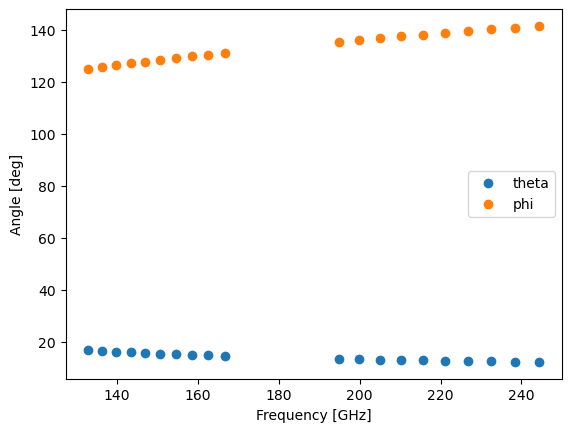

In [12]:
plt.plot(acq.allnus, np.degrees(thetas[:, 0]), 'o', label='theta')
plt.plot(acq.allnus, np.degrees(phis[:, 0]), 'o', label='phi')
plt.legend()
plt.xlabel('Frequency [GHz]')
plt.ylabel('Angle [deg]')

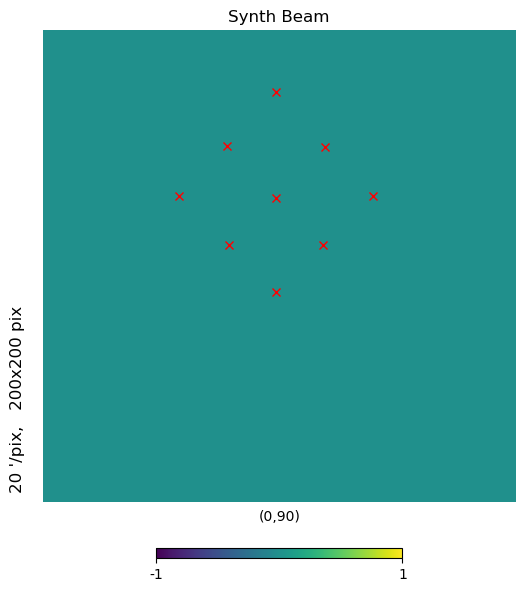

In [13]:
hp.gnomview(np.zeros(hp.nside2npix(nside)), rot=[0,90], reso=20, title="Synth Beam")
hp.projplot(thetas[0], phis[0], 'rx', lonlat=False)

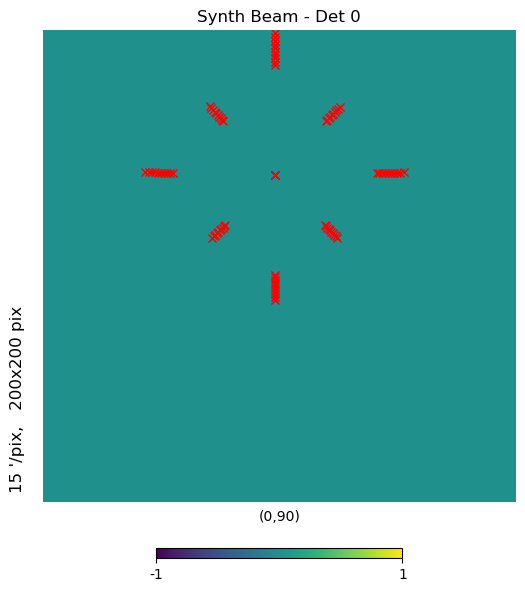

In [14]:
npix = hp.nside2npix(nside)
hp.gnomview(np.zeros(npix), rot=[0,90], reso=15, title=f"Synth Beam - Det {idet}")

for i in range(len(acq.allnus[:nsub])):
    hp.projplot(thetas[i], phis[i], 'rx', lonlat=False)#, label='%.2f GHz' % acq.allnus[i])

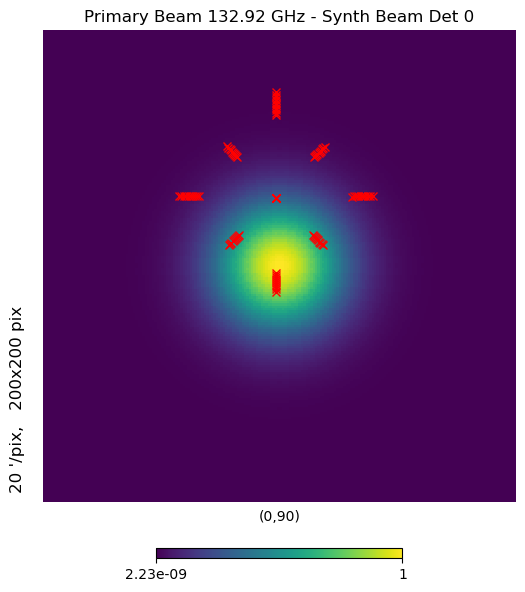

In [15]:
prim1_beam = np.zeros(npix)

# Compute Prim1ary Beam
prim1 = acq.multiinstrument[0].primary_beam
for i in range(npix):
    theta, phi = hp.pix2ang(nside, i)
    prim1_beam[i] = prim1(theta, phi)

hp.gnomview(prim1_beam, rot=[0,90], reso=20, title=f"Primary Beam {acq.allnus[0].round(2)} GHz - Synth Beam Det {idet}")
for i in range(len(acq.allnus[:nsub])):
    hp.projplot(thetas[i], phis[i], 'rx', lonlat=False)#, label='%.2f GHz' % acq.allnus[i])

# Build TOD

In [16]:
# Create uniform maps of "1"
input_maps = np.ones((2*nsub, hp.nside2npix(nside), 3))

# Build the list of sub-TODs
tod = []
for i in range(2*nsub):
    tod.append(Proj_list[i](input_maps[i]))

In [17]:
print("Number of sub-TODs: ", len(tod))
print("sub-TODs shape: ", tod[0].shape, " = (Ndet, Nsample, Nstk)")

Number of sub-TODs:  20
sub-TODs shape:  (992, 1, 3)  = (Ndet, Nsample, Nstk)


# Relative difference between succesive sub-TODs

## Mean on detectors

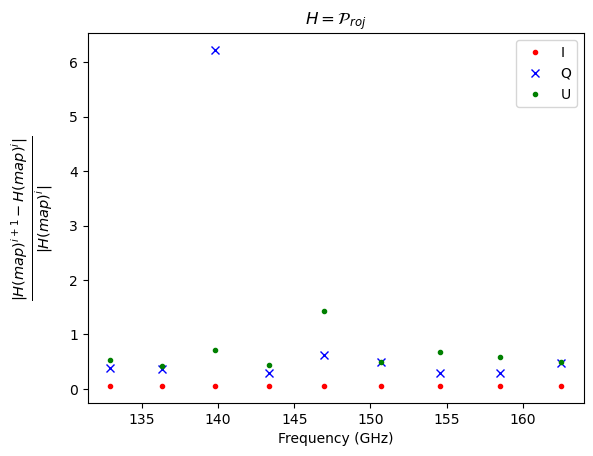

In [18]:
plt.figure()
for i in range(nsub-1):
    diff_I = np.abs((tod[i+1][:, 0, 0] - tod[i][:, 0, 0])/tod[i][:, 0, 0])
    mean_diff_I = np.mean(diff_I)
    plt.plot(acq.allnus[i], mean_diff_I, '.r', label="I" if i==0 else "")
    diff_Q = np.abs((tod[i+1][:, 0, 1] - tod[i][:, 0, 1])/tod[i][:, 0, 1])
    mean_diff_Q = np.mean(diff_Q)
    plt.plot(acq.allnus[i], mean_diff_Q, 'xb', label="Q" if i==0 else "")
    diff_U = np.abs((tod[i+1][:, 0, 2] - tod[i][:, 0, 2])/tod[i][:, 0, 2])
    mean_diff_U = np.mean(diff_U)
    plt.plot(acq.allnus[i], mean_diff_U, '.g', label="U" if i==0 else "")
    
plt.title(r"$H = \mathcal{P}_{roj}$")
plt.ylabel(r'$\frac{| H(map)^{i+1} - H(map)^i |}{| H(map)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel('Frequency (GHz)')
plt.legend()

Text(0.5, 0, 'Frequency (GHz)')

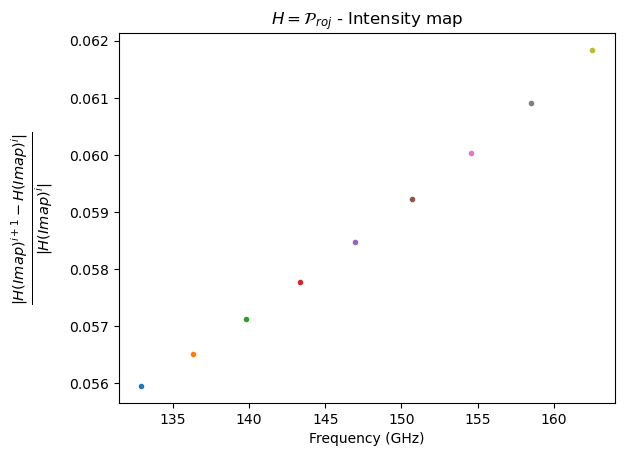

In [19]:
# Intensity
plt.figure()
for i in range(nsub-1):
    diff = np.abs((tod[i+1][:, 0, 0] - tod[i][:, 0, 0])/tod[i][:, 0, 0])
    mean_diff = np.mean(diff)
    plt.plot(acq.allnus[i], mean_diff, '.')
    
plt.title(r"$H = \mathcal{P}_{roj}$ - Intensity map")
plt.ylabel(r'$\frac{| H(Imap)^{i+1} - H(Imap)^i |}{| H(Imap)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel('Frequency (GHz)')

Text(0.5, 0, 'Frequency (GHz)')

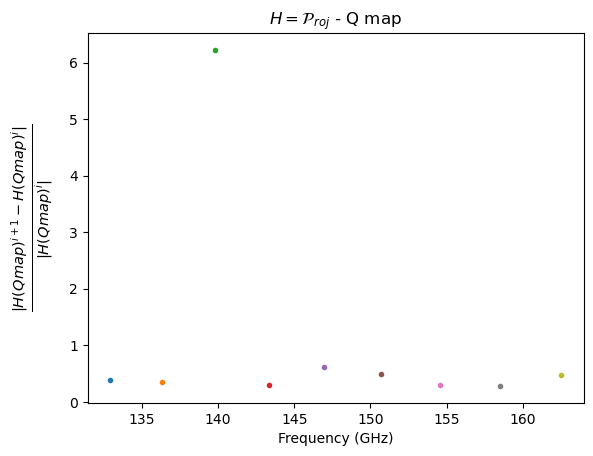

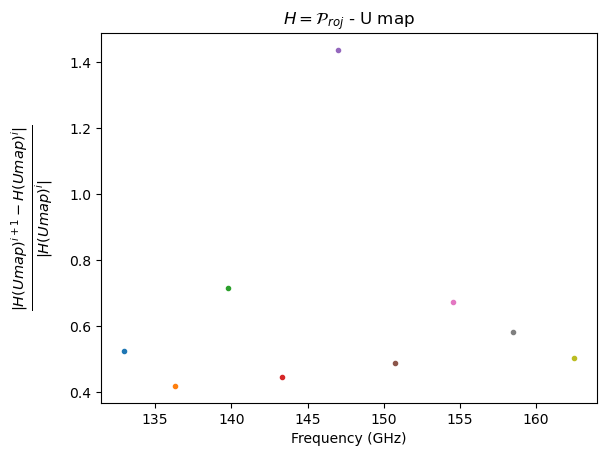

In [20]:
# Polarisation
plt.figure()
for i in range(nsub-1):
    diff = np.abs((tod[i+1][:, 0, 1] - tod[i][:, 0, 1])/tod[i][:, 0, 1])
    mean_diff = np.mean(diff)
    plt.plot(acq.allnus[i], mean_diff, '.')
    
plt.title(r"$H = \mathcal{P}_{roj}$ - Q map")
plt.ylabel(r'$\frac{| H(Qmap)^{i+1} - H(Qmap)^i |}{| H(Qmap)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel('Frequency (GHz)')

plt.figure()
for i in range(nsub-1):
    diff = np.abs((tod[i+1][:, 0, 2] - tod[i][:, 0, 2])/tod[i][:, 0, 2])
    mean_diff = np.mean(diff)
    plt.plot(acq.allnus[i], mean_diff, '.')
    
plt.title(r"$H = \mathcal{P}_{roj}$ - U map")
plt.ylabel(r'$\frac{| H(Umap)^{i+1} - H(Umap)^i |}{| H(Umap)^{i} |}$', fontsize=15, labelpad=10)
plt.xlabel('Frequency (GHz)')

## For each detectors

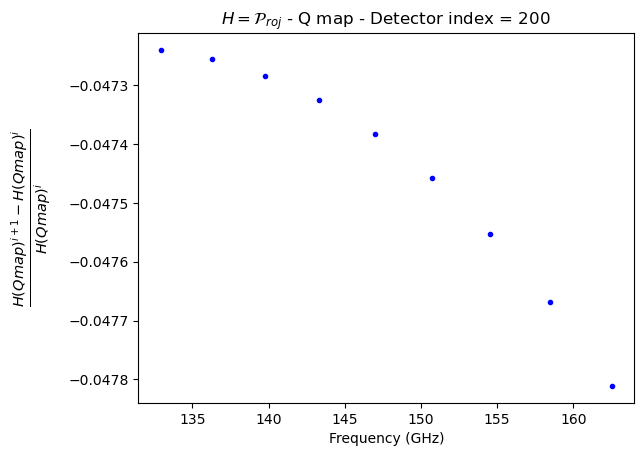

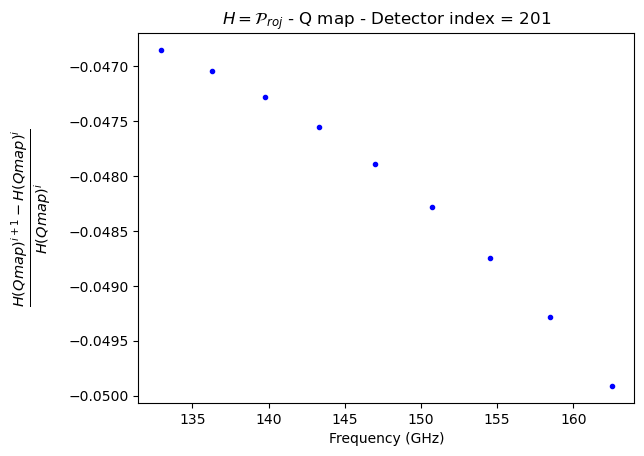

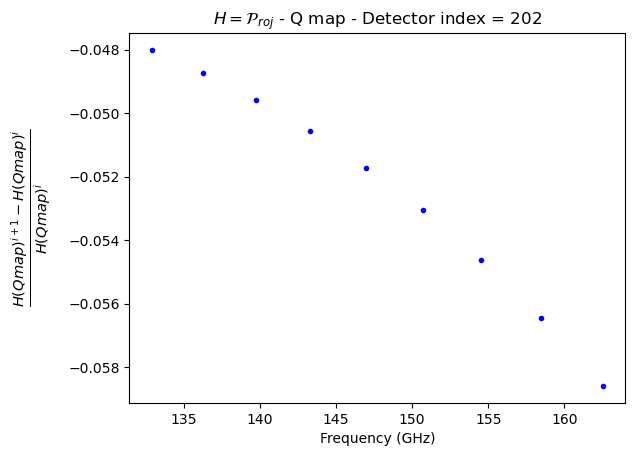

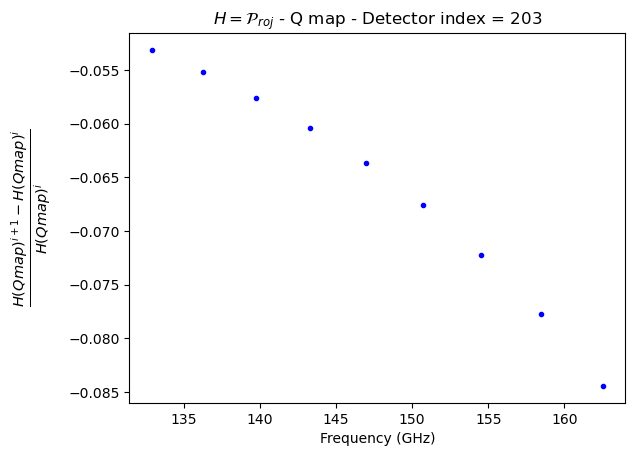

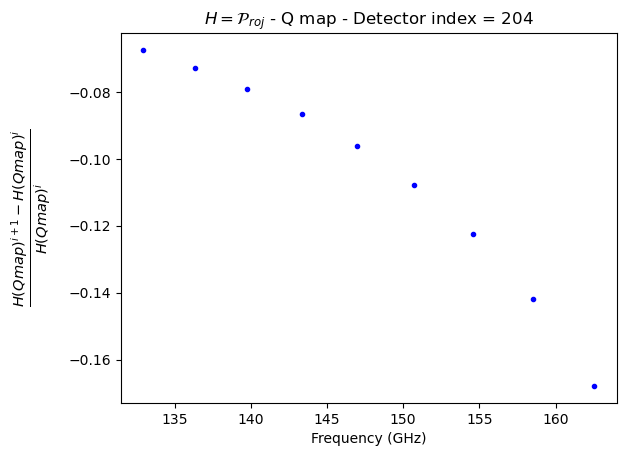

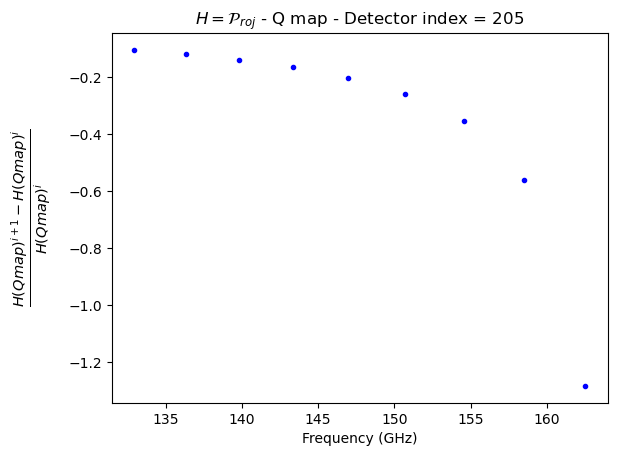

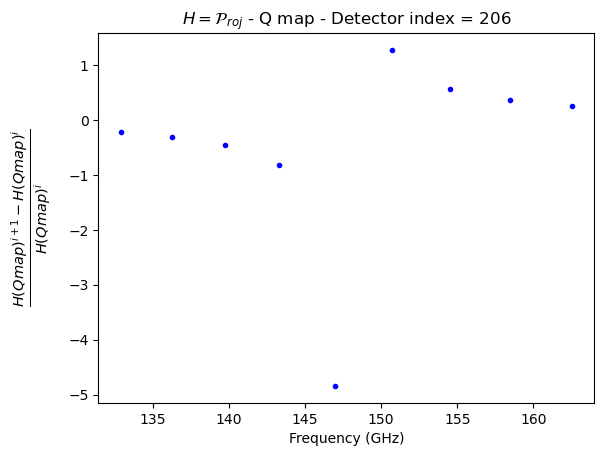

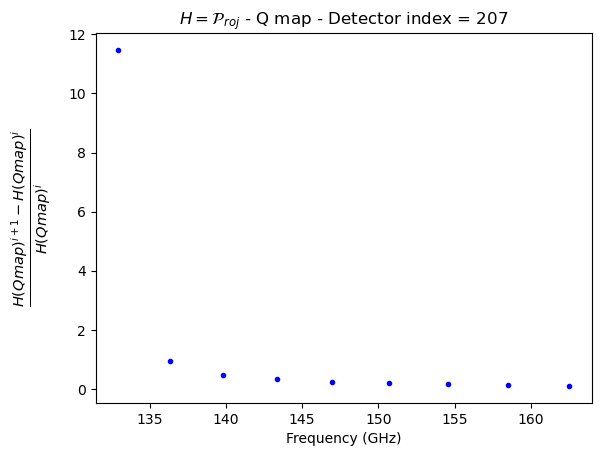

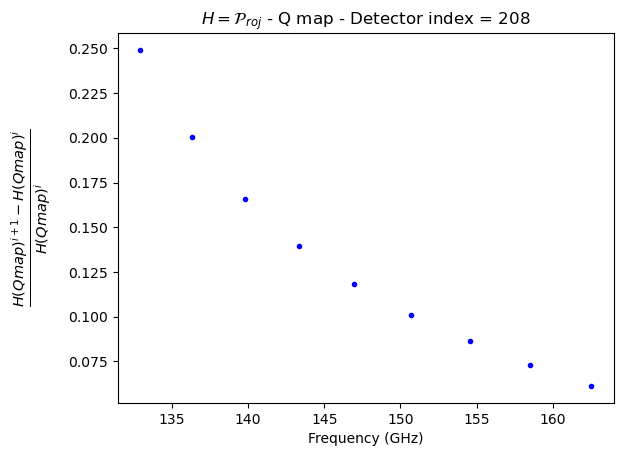

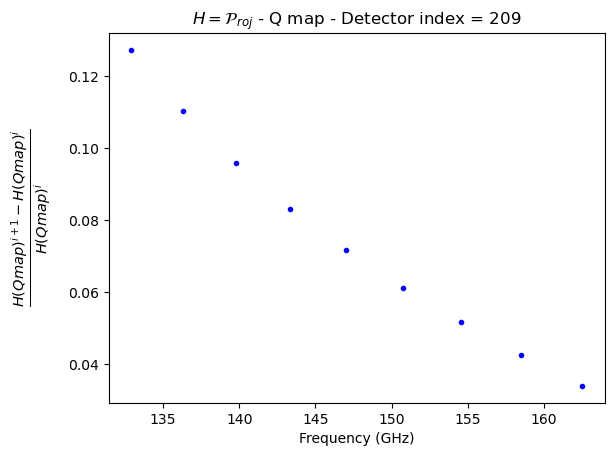

In [21]:
plt.figure()

# Range of detectors for which we want to plot the difference
idet_min, idet_max = 200, 210

for idet in range(idet_min, idet_max):
    for i in range(nsub-1):
        diff = (tod[i+1][idet, 0, 1] - tod[i][idet, 0, 1])/tod[i][idet, 0, 1] #np.abs((tod[i+1][idet, 0, 1] - tod[i][idet, 0, 1])/tod[i][idet, 0, 1])
        plt.plot(acq.allnus[i], diff, '.b')
        
    plt.title(r"$H = \mathcal{P}_{roj}$ - Q map - " + f'Detector index = {idet}')
    plt.ylabel(r'$\frac{ H(Qmap)^{i+1} - H(Qmap)^i }{ H(Qmap)^{i}}$', fontsize=15, labelpad=10)
    plt.xlabel('Frequency (GHz)')
    plt.show()

# Relative difference on the focal plane

Plot the difference between two successive tods, at a given time, on the focal plane. The polarisation case seems very strange with respect to the intensity case.

In [22]:
# Compute the position of the TES in the focal plane
xTES, yTES, vertex = get_TEScoordinates_ONAFP(q)

(992, 1, 3)


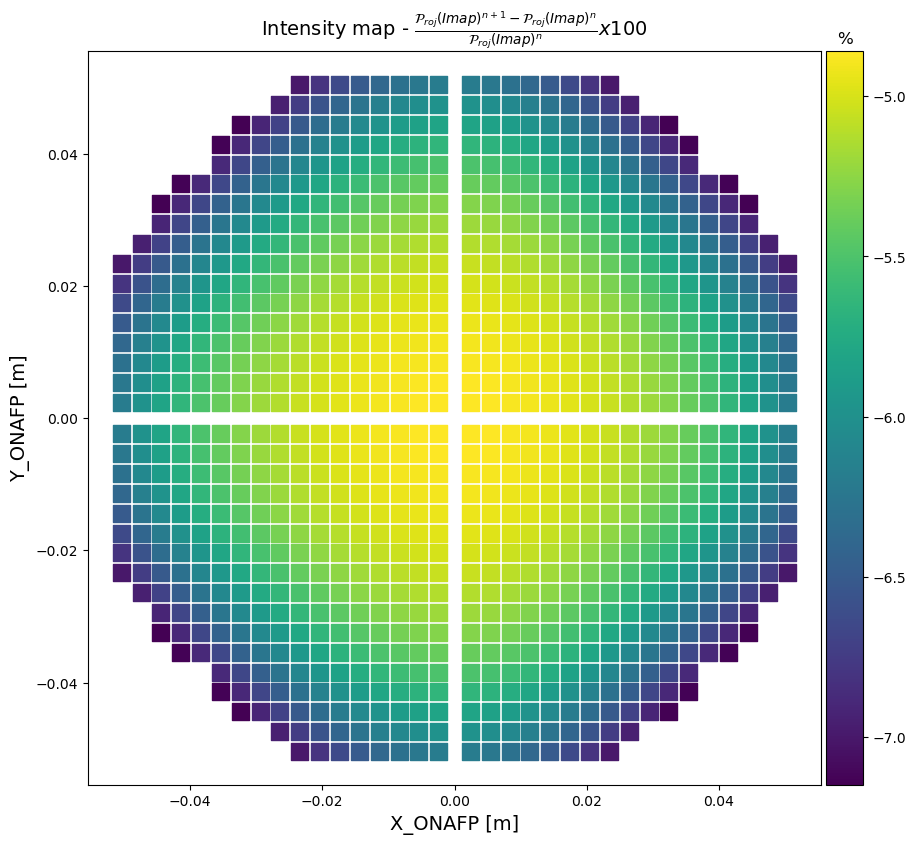

In [23]:
# Sub-bands indices for the comparison
ind_a, ind_b = 3, 2

# Intensity
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = (tod[ind_a]-tod[ind_b])/tod[ind_b]*100
print(relative_diff.shape)
scatter_plot_FP(q, xTES, yTES, np.mean(relative_diff[...,0], axis=1), frame='ONAFP', s=150, title=r'Intensity map - $\frac{ \mathcal{P}_{roj}(Imap)^{n+1} - \mathcal{P}_{roj}(Imap)^{n} }{ \mathcal{P}_{roj}(Imap)^{n} } x 100$', fig=fig, ax = ax, unit='%')

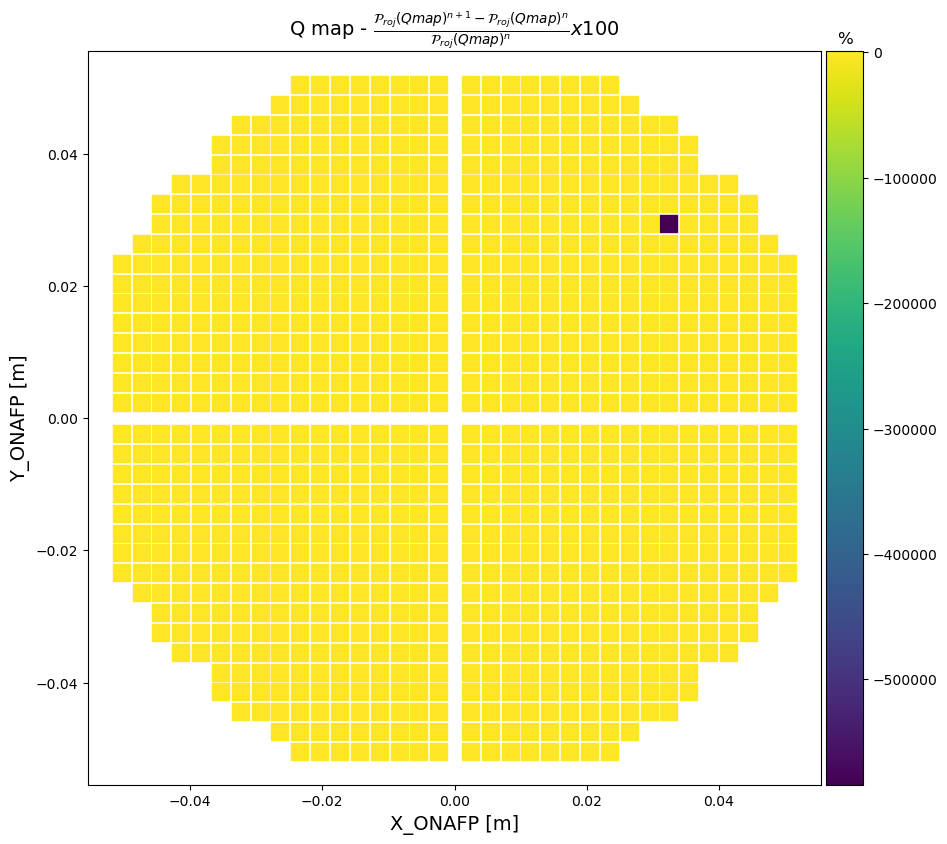

In [24]:
# Polarisation Q
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = (np.abs(tod[ind_a]-tod[ind_b]))/tod[ind_b]*100
scatter_plot_FP(q, xTES, yTES, relative_diff[:, 0, 1], frame='ONAFP', s=150, title=r'Q map - $\frac{ \mathcal{P}_{roj}(Qmap)^{n+1} - \mathcal{P}_{roj}(Qmap)^{n} }{ \mathcal{P}_{roj}(Qmap)^{n} } x 100$', fig=fig, ax = ax, unit='%')

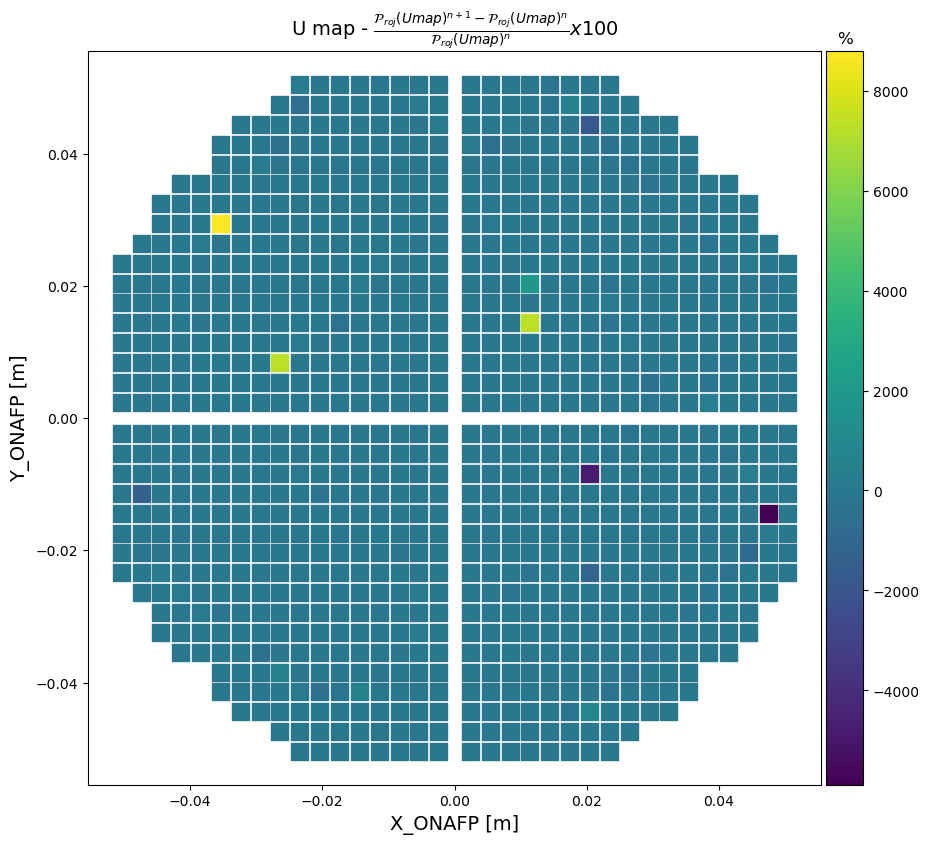

In [25]:
# Polarisation U
fig, ax = plt.subplots(figsize=(10, 10))
relative_diff = (tod[ind_a]-tod[ind_b])/tod[ind_b]*100
scatter_plot_FP(q, xTES, yTES, relative_diff[:, 0, 2], frame='ONAFP', s=150, title=r'U map - $\frac{ \mathcal{P}_{roj}(Umap)^{n+1} - \mathcal{P}_{roj}(Umap)^{n} }{ \mathcal{P}_{roj}(Umap)^{n} } x 100$', fig=fig, ax = ax, unit='%')

# Peak Amplitude evolution with frequency

P.matrix.data is build such that you have all the points for the same detector at all the different time samples, then the next detector at all the different time samples, etc.

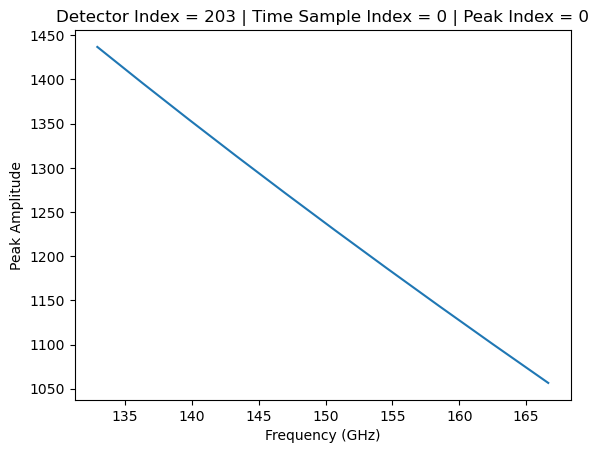

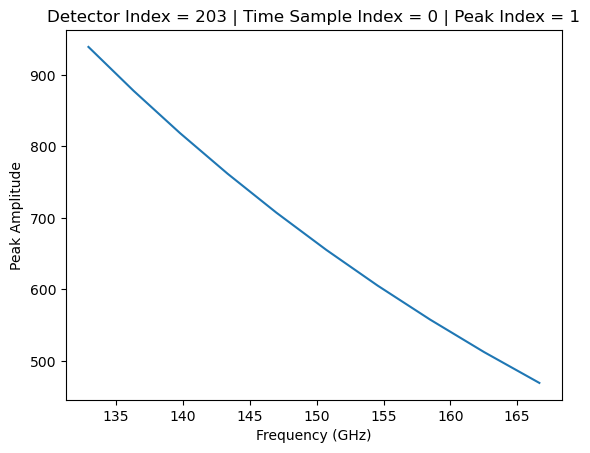

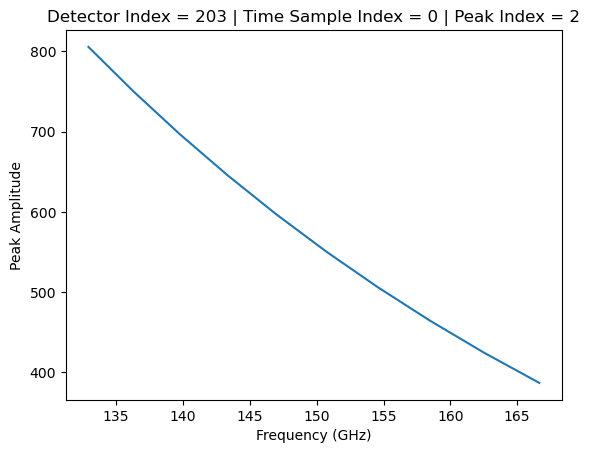

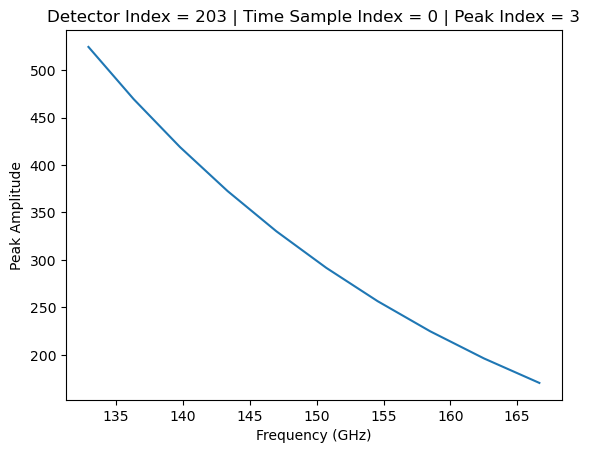

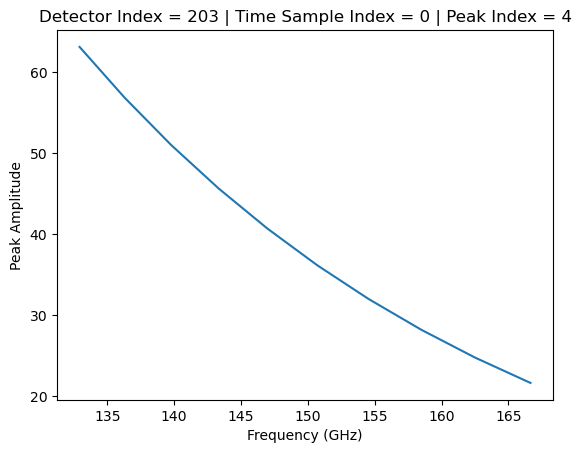

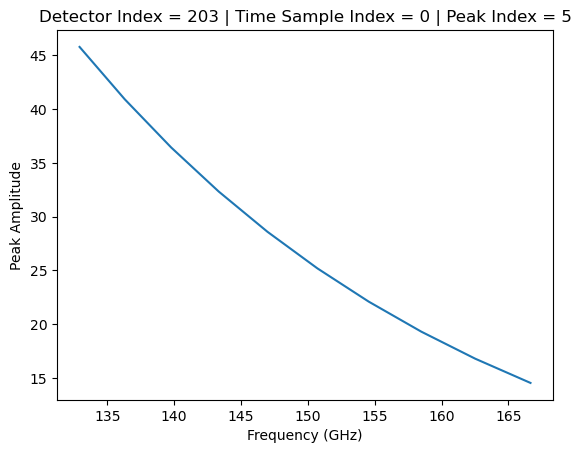

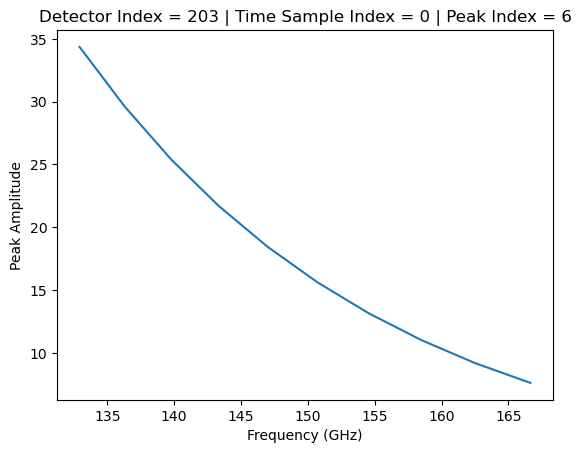

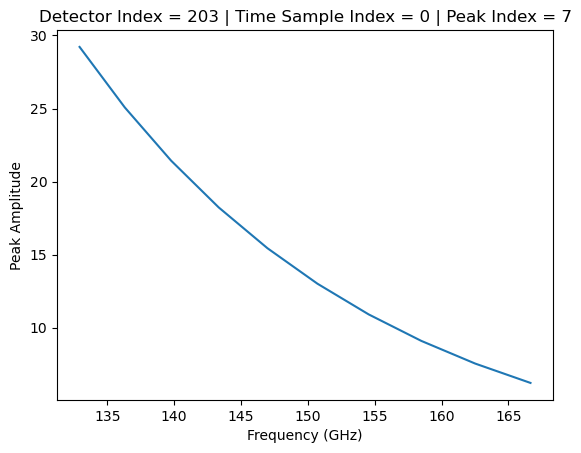

In [26]:
# Indices to compute the amplitude of peaks
peak_index = 0
N_sample = 0
time_index = 0
det_index = 203

# Plot the amplitude of the peak for each sub-band
for peak_index in range((2*dict_qubic['synthbeam_kmax']+1)**2 - 1):
    plt.figure()
    peak_amplitude = []
    for i in range(nsub):
        peak_amplitude.append(Proj_list[i].matrix.data.r11[(det_index*N_sample)+time_index, peak_index])

    plt.plot(acq.allnus[:nsub], peak_amplitude)
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Peak Amplitude")
    plt.title(f"Detector Index = {det_index} | Time Sample Index = {time_index} | Peak Index = {peak_index}")
    plt.show()

# Comparing Primary and Synthesized Beams evolution with frequency

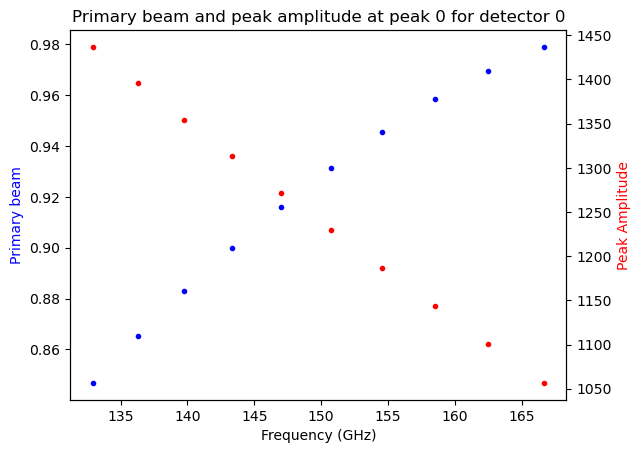

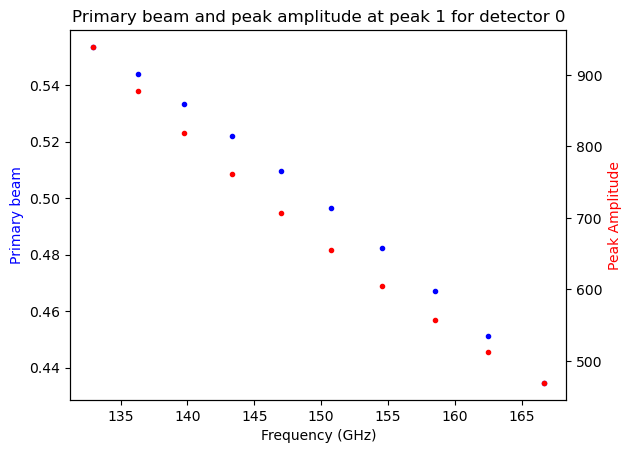

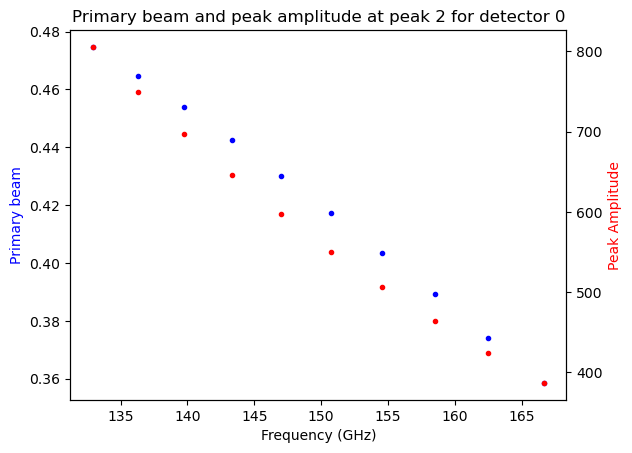

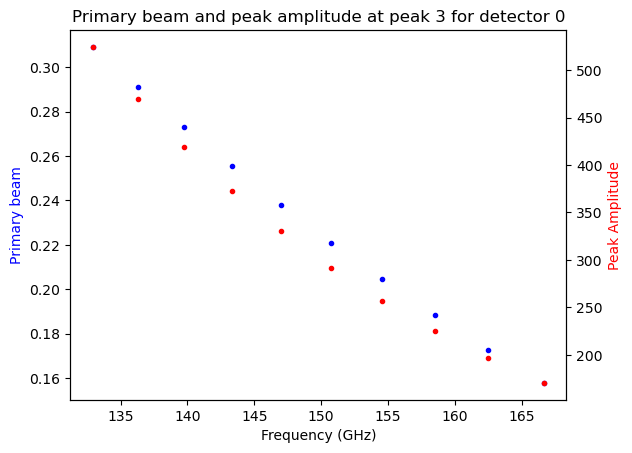

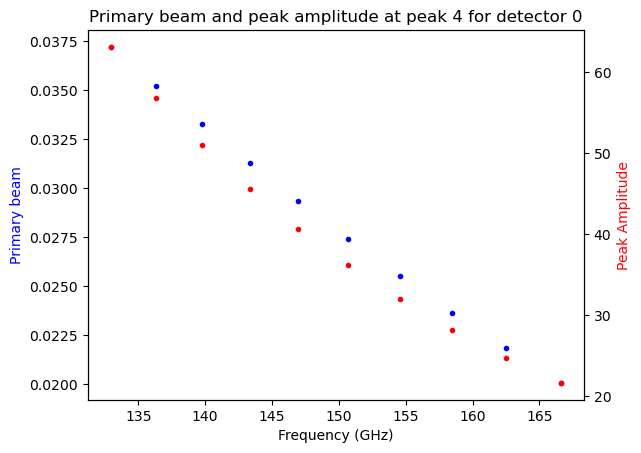

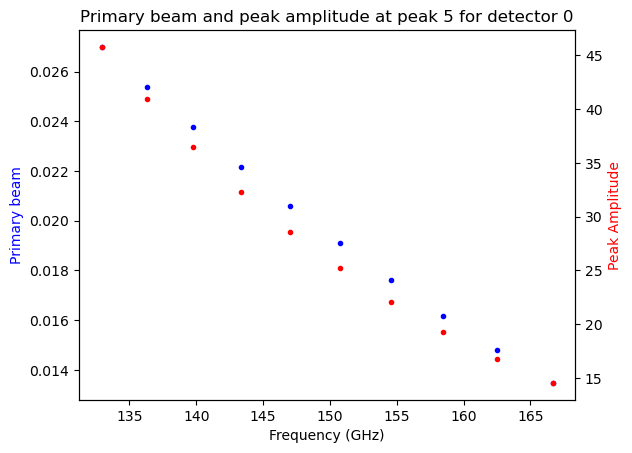

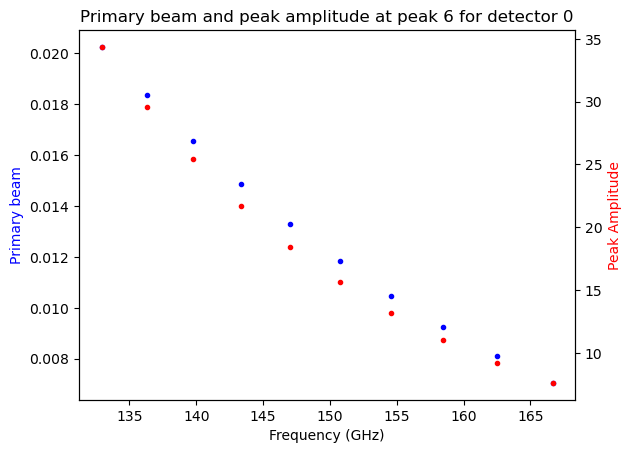

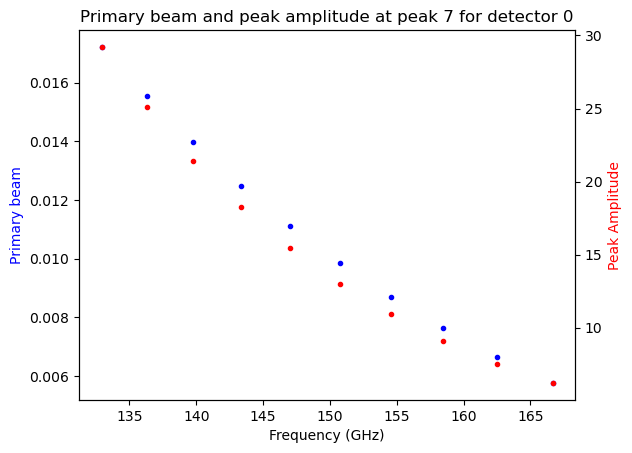

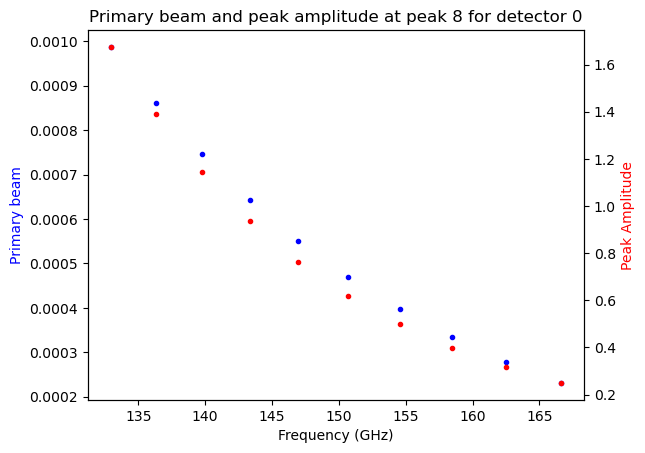

In [27]:
# Indices for the plot
idet = 0
N_sample = 0
time_index = 0

# Store the primary beam for each sub-band
primbeam_frequencies = [acq.multiinstrument[i].primary_beam for i in range(nsub)]

for ipeak in range((2*dict_qubic['synthbeam_kmax']+1)**2):
    peak_amplitude = [] 
    fig, ax1 = plt.subplots()
    for i in range(nsub):
        # Sub-acquisition for the i-th sub-band
        subacq_i = acq.subacqs[i]

        # Compute the peaks position and ampplitude
        th, ph, v = subacq_i.instrument._peak_angles(acq.scene, acq.allnus[i]*1e9, 
                                        subacq_i.instrument.detector.center,
                                        subacq_i.instrument.synthbeam,
                                        subacq_i.instrument.horn,
                                        subacq_i.instrument.primary_beam)

        # Plot the amplitude of the primary beam at peaks' position
        ax1.plot(acq.allnus[i], primbeam_frequencies[i](th[idet, ipeak], ph[idet, ipeak]), '.b')
        
        # Store the amplitude of the peak
        # Note: I checked that both gives the same result 
        peak_amplitude.append(v[idet, ipeak])
        #peak_amplitude.append(Proj_list[i].matrix.data.r11[(idet*N_sample)+time_index, ipeak])

    ax1.set_xlabel('Frequency (GHz)')
    ax1.set_ylabel('Primary beam', color = 'blue')
    ax1.set_title('Primary beam and peak amplitude at peak %d for detector %d' % (ipeak, idet))

    ax2 = ax1.twinx()
    ax2.plot(acq.allnus[:nsub], peak_amplitude, '.r')
    ax2.set_ylabel("Peak Amplitude", color = 'r')
    plt.show()